In [1]:

import os
import sys
import pandas as pd
import logging
import labelbox
import matplotlib.pyplot as plt


# Extend the system path to include the parent directory for module imports.
sys.path.append(os.path.abspath('..'))

# Import constants and utility functions from utils module.
from utils.utils_constants import (
    VESSEL_NEPTUNE_PAT_INFO_PATH as PAT_INFO_PATH,
    COMBINED_CLASSIFICATION_PATH,
    CLASSIFICATION_PATH,
    LABELBOX_API_KEY,
    PROJECT_KEY_1,
    PROJECT_KEY_2,
    PROJECT_KEY_REMOVE
)


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
def export_labelbox_project(api_key, project_key):

	client = labelbox.Client(api_key=api_key) 
	params = {
		"data_row_details": True,
		"metadata_fields": True,
		"attachments": True,
		"project_details": True,
		"performance_details": True,
		"label_details": True,
		"interpolated_frames": True
	}
	project = client.get_project(project_key)
	export_task = project.export_v2(params=params)

	export_task.wait_till_done()
	if export_task.errors:
		print(export_task.errors)
	export_json = export_task.result
	return export_json

export_json_proj_1 = export_labelbox_project(LABELBOX_API_KEY, PROJECT_KEY_1)
export_json_proj_2 = export_labelbox_project(LABELBOX_API_KEY, PROJECT_KEY_2)
export_json_proj_remove = export_labelbox_project(LABELBOX_API_KEY, PROJECT_KEY_REMOVE)

2024-06-25 18:13:38,972 - INFO - Initializing Labelbox client at 'https://api.labelbox.com/graphql'
2024-06-25 18:14:03,325 - INFO - Initializing Labelbox client at 'https://api.labelbox.com/graphql'
2024-06-25 18:15:23,149 - INFO - Initializing Labelbox client at 'https://api.labelbox.com/graphql'


In [3]:

def process_export_json_to_df(export_json, project_key):
	# Collect artery classification data
	rows = []

	for item in export_json:
		image_name = item['data_row']['external_id']
		row = {"Image Name": image_name}

		if len(item['projects'][project_key]['labels']) == 0: 
			print(image_name, " has no label yet")
			rows.append(row)
			continue

		assert len(item['projects'][project_key]['labels']) == 1, "Unexpected number of labels."
		classifications = item['projects'][project_key]['labels'][0]['annotations']['classifications']
		for classification in classifications:
			if 'radio_answer' in classification:
				question = classification['name']
				answer = classification['radio_answer']['name']
				row[question] = answer

		rows.append(row)

	df_artery_classification = pd.DataFrame(rows)
	return df_artery_classification

df_proj_1 = process_export_json_to_df(export_json_proj_1, PROJECT_KEY_1)
df_proj_2 = process_export_json_to_df(export_json_proj_2, PROJECT_KEY_2)
df_proj_remove = process_export_json_to_df(export_json_proj_remove, PROJECT_KEY_REMOVE)

In [4]:
to_remove_images = df_proj_remove.loc[df_proj_remove.loc[:, "Remove?"]=="Yes", "Image Name"].values

In [5]:
df_artery_classification = pd.concat([df_proj_1, df_proj_2], axis=0)
df_artery_classification = df_artery_classification.loc[~df_artery_classification.loc[:, "Image Name"].isin(to_remove_images), :]
df_artery_classification = df_artery_classification.rename(columns={'Hylinosis Severity': 'Hyalinosis Severity'})
# Extract "Artery ID" and "Bounding Box" from "Image Name"
df_artery_classification["Artery ID"] = df_artery_classification["Image Name"].apply(lambda x: os.path.splitext(x)[0].split("_")[4])
df_artery_classification["Bounding Box"] = df_artery_classification["Image Name"].apply(lambda x: ", ".join(os.path.splitext(x)[0].split("_")[5:9]))
cols = df_artery_classification.columns.tolist()
new_order = ['Image Name', 'Artery ID', 'Bounding Box'] + [col for col in cols if col not in ['Image Name', 'Artery ID', 'Bounding Box']]
df_artery_classification = df_artery_classification[new_order]
df_artery_classification.to_csv(COMBINED_CLASSIFICATION_PATH, index=False)

In [ ]:
# # Filter to select rows where 'Artery Type' is 'Arcuate Arteries' and 'Hyalinosis Severity' is greater than 0
# condition = (df_artery_classification['Artery Type'] == 'Arcuate Arteries') & (df_artery_classification['Hyalinosis Severity'] > 0)
# df_artery_classification.loc[condition, 'Arteriosclerosis Severity'] = df_artery_classification.loc[condition, 'Hyalinosis Severity']
# condition = (df_artery_classification['Artery Type'] == 'Arcuate Arteries') & (df_artery_classification['Hyalinosis Severity'] > 1)
# df_artery_classification.loc[condition, 'Hyalinosis Severity'] = 0

In [6]:
pat_df = pd.read_csv(PAT_INFO_PATH)

# Load the previously saved artery classification data
df_artery_classification = pd.read_csv(COMBINED_CLASSIFICATION_PATH)
# Initialize Excel writer
excel_writer = pd.ExcelWriter(CLASSIFICATION_PATH, engine='xlsxwriter')

for index, row in pat_df.iterrows():
    fake_wsi_filename = row["WSI_Selected_Fake_Name"]
    # Filter the DataFrame based on the fake filename
    df_filtered_by_wsi = df_artery_classification[df_artery_classification["Image Name"].str.contains(fake_wsi_filename)]    
    if not df_filtered_by_wsi.empty:        
        # Use the WSI Selected filename for the sheet name, ensuring it's within Excel's limit of 31 characters
        sheet_name = os.path.splitext(row["WSI_Selected"])[0]
        df_filtered_by_wsi.to_excel(excel_writer, sheet_name=sheet_name, index=False)

        # Get the xlsxwriter workbook and worksheet objects.
        # workbook = excel_writer.book
        worksheet = excel_writer.sheets[sheet_name]

        # Loop through the columns and set the column width as desired
        for i, col in enumerate(df_filtered_by_wsi.columns):
            # Set the column width
            column_len = max(df_filtered_by_wsi[col].astype(str).apply(len).max(), len(col)) + 2  # Adding a little extra space
            worksheet.set_column(i, i, column_len)

        print(f"Saved sheet for {sheet_name} with {len(df_filtered_by_wsi)} entries.")

excel_writer.close()
print("Excel file with differentiated sheets saved successfully.")

Saved sheet for 10_26609_000_002_L2_TRI with 12 entries.
Saved sheet for 11_26609_000_009_L2_TRI with 28 entries.
Saved sheet for 11_26609_000_012_L02_TRI with 9 entries.
Saved sheet for 11_26609_000_013_L02 TRI with 11 entries.
Saved sheet for 0_784_A_0047801 with 18 entries.
Saved sheet for 0_796_A_0047806 with 29 entries.
Saved sheet for 0_800_A_0047811 with 16 entries.
Saved sheet for 11_26609_000_503_L2_TRI with 18 entries.
Saved sheet for 11_26609_001_004 L7 TRI with 3 entries.
Saved sheet for 13_26609_001_013 LUNK1 TRI with 8 entries.
Saved sheet for 12_26609_001_501 LUNK TRI with 6 entries.
Saved sheet for 0_2852_A_0052807 with 14 entries.
Saved sheet for 0_2854_A_0052814 with 17 entries.
Saved sheet for 0_2856_A_0052824 with 5 entries.
Saved sheet for 16_26609_001_515 L07 TRI with 11 entries.
Saved sheet for 0_2862_A_0053442 with 14 entries.
Saved sheet for 0_2868_A_0049982 with 9 entries.
Saved sheet for 0_954_A_0056426 with 7 entries.
Saved sheet for 11_26609_009_005 L10 TRI

In [7]:
ARTERY_TYPES = ["Arterioles", "Interlobular Arteries", "Arcuate Arteries"]
print(len(df_artery_classification[df_artery_classification['Artery Type'] == "Others"]))
df_artery_classification = df_artery_classification[df_artery_classification['Artery Type'] != "Others"]
df_artery_classification['Artery Type'] = pd.Categorical(df_artery_classification['Artery Type'], categories=ARTERY_TYPES)
print(len(df_artery_classification))

609
2335


/tmp/ipykernel_108954/3226916337.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severity_counts = df_artery_classification.groupby(['Artery Type', 'Arteriosclerosis Severity']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

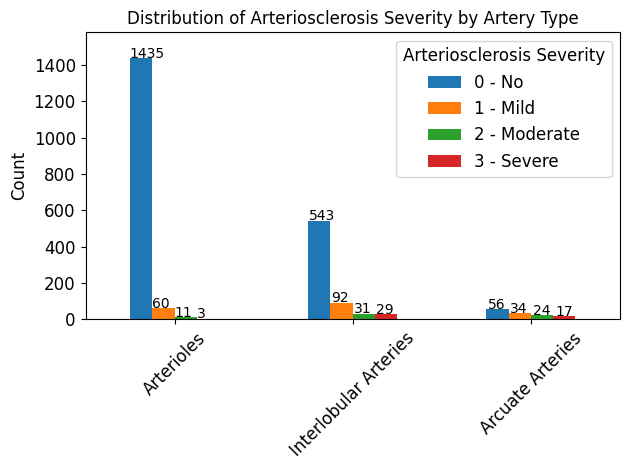

In [8]:
# Count occurrences of each severity level within each Artery Type
severity_counts = df_artery_classification.groupby(['Artery Type', 'Arteriosclerosis Severity']).size().unstack(fill_value=0)

# Plotting adjustments
plt.figure(figsize=(10, 6))
ax = severity_counts.plot(kind='bar')
plt.title('Distribution of Arteriosclerosis Severity by Artery Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=10)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='Arteriosclerosis Severity', fontsize=12, title_fontsize=12)

# Find the maximum height among all the bars
max_height = max([p.get_height() for p in ax.patches])

# Increase the y-axis limit to provide space for annotations
plt.ylim(0, max_height * 1.1)  # Increase by 10%


# Adding numbers on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height()+2), fontsize=10)

# Adjusting the layout
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_108954/728966043.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severity_counts = df_artery_classification.groupby(['Artery Type', 'Hyalinosis Severity']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

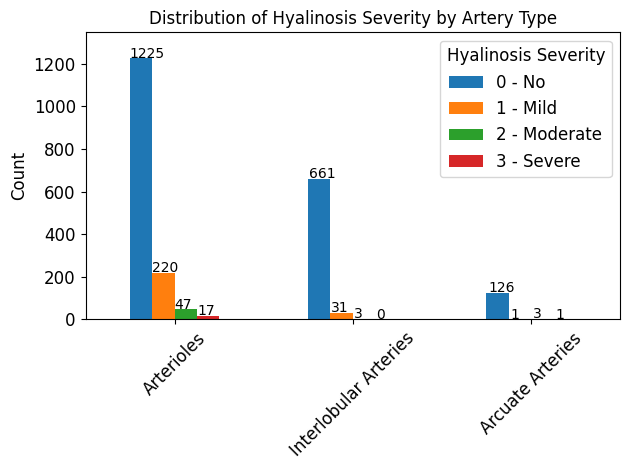

In [9]:
# Count occurrences of each severity level within each Artery Type
severity_counts = df_artery_classification.groupby(['Artery Type', 'Hyalinosis Severity']).size().unstack(fill_value=0)

# Plotting adjustments
plt.figure(figsize=(10, 6))
ax = severity_counts.plot(kind='bar')
# plt.title('Distribution of Hyalinosis Severity by Artery Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Hyalinosis Severity', fontsize=12, title_fontsize=12)

plt.title('Distribution of Hyalinosis Severity by Artery Type', fontsize=12)
# Find the maximum height among all the bars
max_height = max([p.get_height() for p in ax.patches])

# Increase the y-axis limit to provide space for annotations
plt.ylim(0, max_height * 1.1)  # Increase by 10%
# Adding numbers on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height()+2), fontsize=10)

# Adjusting the layout
plt.tight_layout()

# Show the plot
plt.show()
